# Libraries

In [158]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model & Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    average_precision_score, 
    precision_recall_curve
)

# Load Dataset

In [159]:
df = pd.read_csv("titanic_dataset.csv")

# Initial information about dataset
df.info()

# Drop Cabin column (too many missing values)
df = df.drop(columns=["Cabin"])
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
df["Title"] = df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
df["Title"] = df["Title"].replace(
    ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
     'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  FamilySize   1309 non-null   int64  
 12  IsAlone      1309 non-null   int64  
 13  Title        1309 non-null   object 
dtypes: float64(2), int64(7), object(5)
memory usage: 143.3+ KB


# Exploratory Data Analysis (EDA)

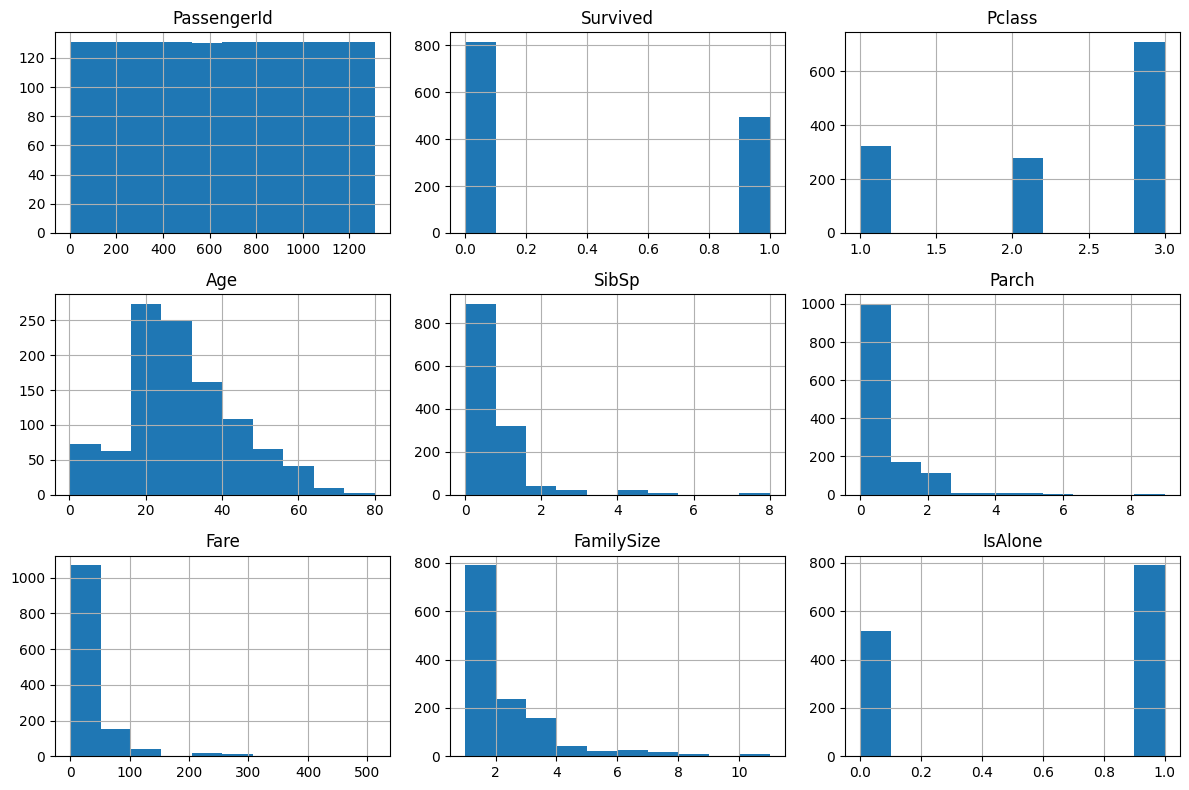

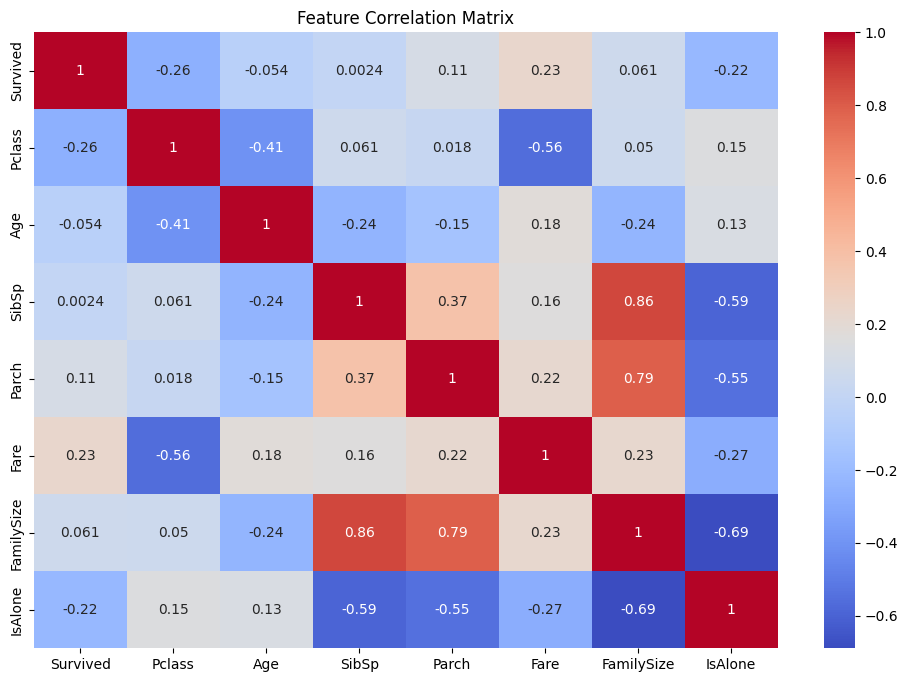

In [161]:
# Histogram of all numerical features
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
df_num = df.select_dtypes(include="number").drop(columns="PassengerId")
corr_matrix = df_num.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

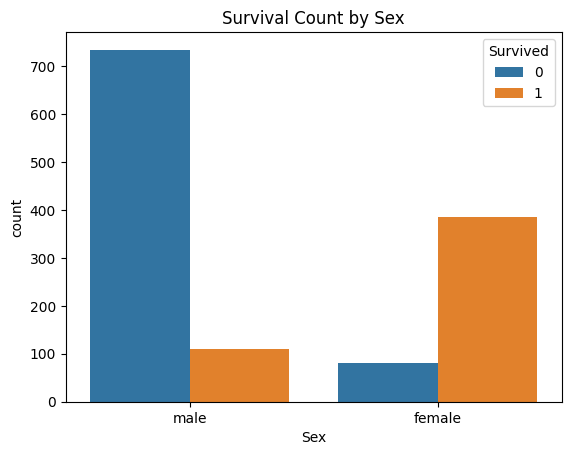

In [162]:
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Survival Count by Sex')
plt.show()


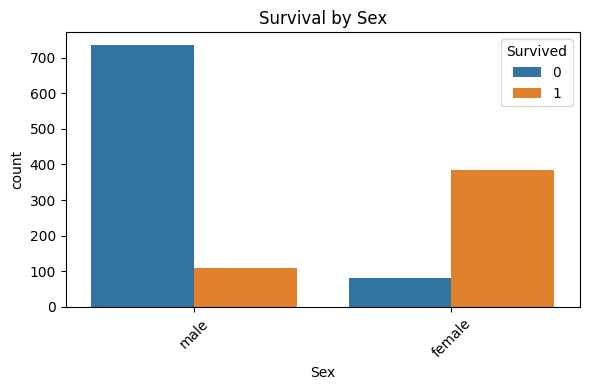

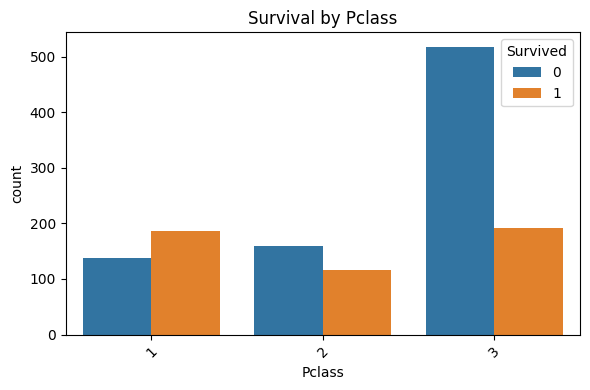

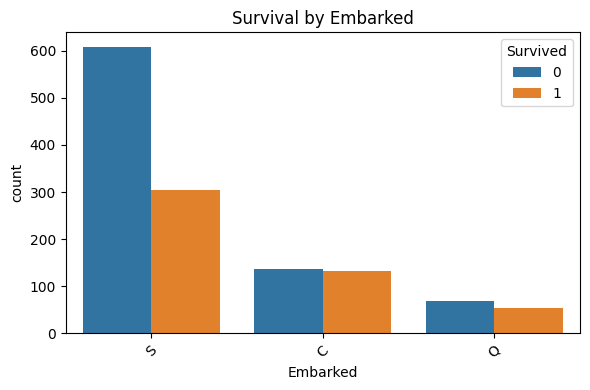

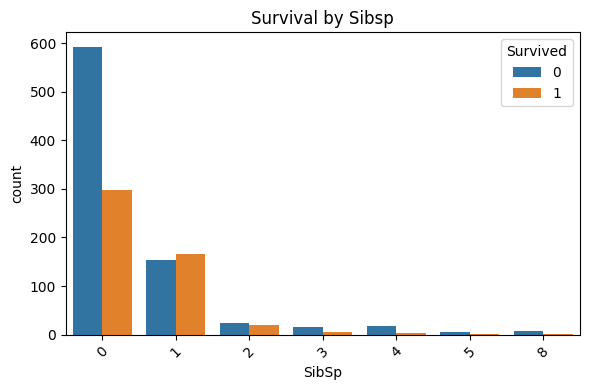

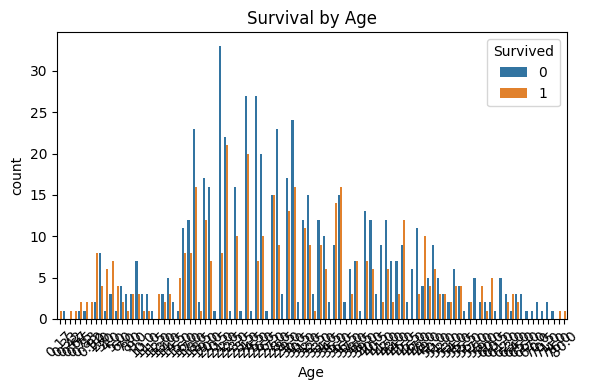

In [163]:
categorical_cols = ['Sex', 'Pclass', 'Embarked','SibSp', 'Age']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='Survived')
    plt.title(f'Survival by {col.capitalize()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Train/Test Split


In [164]:
X = df.drop(columns=["PassengerId", "Survived"])
y = df["Survived"]

# Class distribution check (imbalance analysis)
print(df['Survived'].value_counts())

# Stratified split to preserve target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

# Separate categorical and numerical columns


df_num = X.select_dtypes(include="number")
num_cols = df_num.columns.to_list()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Categorical:", cat_cols, "\nNumerical:", num_cols)



Survived
0    815
1    494
Name: count, dtype: int64
Categorical: ['Name', 'Sex', 'Ticket', 'Embarked', 'Title'] 
Numerical: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']


# Preprocessing Pipeline


In [165]:
from sklearn.preprocessing import StandardScaler
pipe_num = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
imputer = SimpleImputer(strategy='most_frequent')

# Categorical preprocessing (impute + one-hot-encode)
pipe_pre = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Column transformer (only categorical preprocessing here)
ct = ColumnTransformer([
    ("num", pipe_num, num_cols),
    ("cat", pipe_pre, cat_cols)
])

In [166]:
missing = [c for c in (num_cols + cat_cols) if c not in X.columns]
print("Missing columns (should be empty):", missing)

Missing columns (should be empty): []


# Model Definition

In [167]:
model_rf = RandomForestClassifier(random_state=42, 
                                  n_estimators=200,
                                  max_depth=10)

# Full pipeline: preprocessing + model
pipe_main = Pipeline([
    ("pre", ct),
    ("clf", model_rf)
])

In [168]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [5, 10, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}
# Grid search with cross-validation
grid_rf = GridSearchCV(pipe_main, param_grid, 
                       cv=5, scoring="f1", n_jobs=-1, verbose=2)

grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best F1 Score:", grid_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Best F1 Score: 0.8305794603048099


In [169]:
from xgboost import XGBClassifier

# Pipeline with XGBoost
pipe_xgb = Pipeline([
    ("pre", ct),
    ("clf", XGBClassifier( eval_metric="logloss", random_state=42))
])

# Example parameter grid for XGBoost
param_grid_xgb = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__subsample": [0.8, 1.0]
}

grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb,
                        cv=5, scoring="f1", n_jobs=-1, verbose=2)

grid_xgb.fit(X_train, y_train)

print("Best Parameters (XGB):", grid_xgb.best_params_)
print("Best F1 Score (XGB):", grid_xgb.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (XGB): {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Best F1 Score (XGB): 0.8256942253073511


In [170]:
best_params = grid_xgb.best_params_
xgb_params = {k.split("__",1)[1]: v for k,v in best_params.items()}  # remove "clf__"
pipe_xgb_tuned = Pipeline([
    ("pre", ct),
    ("clf", XGBClassifier(
        **xgb_params, eval_metric="logloss", random_state=42
    ))
])
pipe_xgb_tuned.fit(X_train, y_train)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model Training


In [171]:
pipe_main.fit(X_train, y_train)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Baseline Evaluation (Default Threshold = 0.5)

In [172]:
# Predictions
y_pred_base = pipe_main.predict(X_test)

# Accuracy & F1
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline F1:", f1_score(y_test, y_pred_base))

Baseline Accuracy: 0.8564814814814815
Baseline F1: 0.7973856209150327


In [173]:
y_pred_xbg = pipe_xgb_tuned.predict(X_test)
# Accuracy & F1
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_xbg))
print("Baseline F1:", f1_score(y_test, y_pred_xbg))

Baseline Accuracy: 0.8611111111111112
Baseline F1: 0.8064516129032258


# Precision-Recall Analysis (Finding Best Threshold)


In [178]:
# Predicted probabilities
proba_test = pipe_main.predict_proba(X_test)[:, 1]

# Average Precision (area under PR curve)
ap = average_precision_score(y_test, proba_test)
print(f"Average Precision (PR-AUC): {ap:.3f} | Baseline ~ {y.mean():.3f}")

# Precision-Recall curve to find best F1 threshold
prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1s = (2*prec*rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best F1={f1s[best_idx]:.3f} at threshold={best_thr:.3f}")
acuuracy = accuracy_score(y_test, proba_test >= best_thr)
print(f"acuuracy:{acuuracy} ")

Average Precision (PR-AUC): 0.887 | Baseline ~ 0.377
Best F1=0.819 at threshold=0.350
acuuracy:0.8657407407407407 


In [175]:
# Predicted probabilities
proba_test_gxbo = pipe_xgb_tuned.predict_proba(X_test)[:, 1]

# Average Precision (area under PR curve)
ap = average_precision_score(y_test, proba_test_gxbo)
print(f"Average Precision (PR-AUC): {ap:.3f} | Baseline ~ {y.mean():.3f}")

# Precision-Recall curve to find best F1 threshold
prec, rec, thr = precision_recall_curve(y_test, proba_test_gxbo)
f1s = (2*prec*rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best F1={f1s[best_idx]:.3f} at threshold={best_thr:.3f}")

Average Precision (PR-AUC): 0.883 | Baseline ~ 0.377
Best F1=0.817 at threshold=0.332


# Final Evaluation (Optimized Threshold)


In [176]:
# Apply custom threshold
y_pred_xgboo = (proba_test_gxbo >= best_thr).astype(int)

print("Final F1:", f1_score(y_test, y_pred_xgboo))
print("Final Accuracy:", accuracy_score(y_test, y_pred_xgboo))

Final F1: 0.8170731707317073
Final Accuracy: 0.8611111111111112
